# Timelag Sandbox
Play around with creating a new object for dealing with cubes of AIA data and computing timelags from them with Dask

In [1]:
import sys
import dask.bytes
import dask.array as da
import dask.dataframe as df
import dask
import distributed
from dask import delayed, compute
from astropy.io import fits
from astropy.time import Time
import astropy.units as u
from astropy.io.fits.hdu.base import BITPIX2DTYPE
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import sunpy.map
from sunpy.util.metadata import MetaDict
from astropy.coordinates import SkyCoord
from sunpy.physics.differential_rotation import solar_rotate_coordinate
from sunpy.physics.differential_rotation import diffrot_map
#from header_helpers import validate_dtype_shape
from sunpy.instr.aia import aiaprep
#from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append('../scripts/')
from aiacube import DistributedAIACube
from timelags import AIATimeLags
from idl_colormaps import bgry_004_idl_cmap

Define the instrument 

In [2]:
#aia = InstrumentSDOAIA([0,1]*u.s,None)

Define some functions for constructing a Dask array from a bunch of FITS files

Spin up the Dask cluster

In [3]:
cluster = distributed.LocalCluster(n_workers=64,threads_per_worker=1,)
client = distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34121 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Construct the Dask array

In [4]:
channels = [94,131,171,193,211,335]

In [5]:
#read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/{}/map_t*.fits'
#read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_*_{}_cutout.fits'
read_template = '/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/nei/SDO_AIA/{}/map_t{:06d}.fits'

In [6]:
aiatimelags = AIATimeLags(*[DistributedAIACube.from_files([read_template.format(c,i) for i in range(500,2500)]) for c in channels])

In [13]:
cube_test = aiatimelags['171.0'].rechunk((aiatimelags['171.0'].shape[0],
                                          aiatimelags['171.0'].shape[1]//10,
                                          aiatimelags['171.0'].shape[2]//10))
time_test = aiatimelags['171.0'].time

In [15]:
print(cube_test.shape,cube_test.chunks)

(2000, 519, 543) ((2000,), (51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 9), (54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 3))


In [10]:
time_test.shape

(2000,)

In [12]:
cube_interp = aiatimelags._interpolate(cube_test,time_test)

(2000,)
(1,)


ValueError: fp and xp are not of the same length.

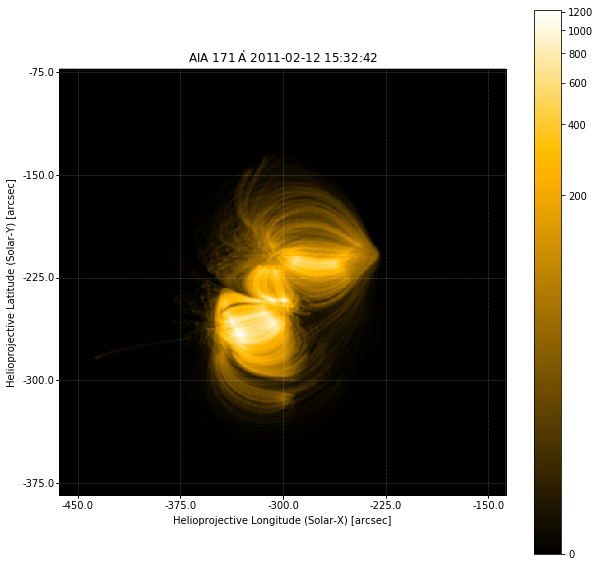

In [8]:
fig = plt.figure(figsize=(10,10))
intensity_average = aiatimelags['171.0'].average()
intensity_average = sunpy.map.Map(intensity_average.data.compute(),intensity_average.meta)
ax = fig.gca(projection=intensity_average)
im = intensity_average.plot(axes=ax,)
fig.colorbar(im,ax=ax)

In [14]:
ts94 = aiatimelags.make_timeseries(94.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))
ts171 = aiatimelags.make_timeseries(171.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))
ts94 = (ts94 - ts94.mean())/ts94.std()
ts171 = (ts171 - ts171.mean())/ts171.std()

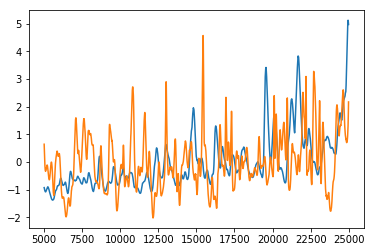

In [16]:
plt.plot(aiatimelags['94.0'].time, ts94)
plt.plot(aiatimelags['171.0'].time, ts171)
#plt.yscale('log')

In [30]:
cc94_335 = aiatimelags.correlation_1d(94.0,335.0,(-310*u.arcsec,-225*u.arcsec),(-300*u.arcsec,-215*u.arcsec))

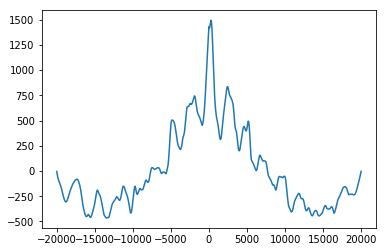

In [31]:
plt.plot(aiatimelags.timelags,cc94_335)

In [25]:
np.all(np.linspace(aiatimelags['94.0'].time.min(),aiatimelags['94.0'].time.max(),aiatimelags['94.0'].time.shape[0]) == aiatimelags['94.0'].time)

True

<Quantity [ 5000.,  5010.,  5020., ..., 24970., 24980., 24990.] s>

In [32]:
tl_map94_335 = aiatimelags.make_timelag_map(94.0,335.0,timelag_bounds=(-6*u.hour,6*u.hour))

In [33]:
cor_map94_335 = aiatimelags.make_correlation_map(94.0,335.0,timelag_bounds=(-6*u.hour,6*u.hour))

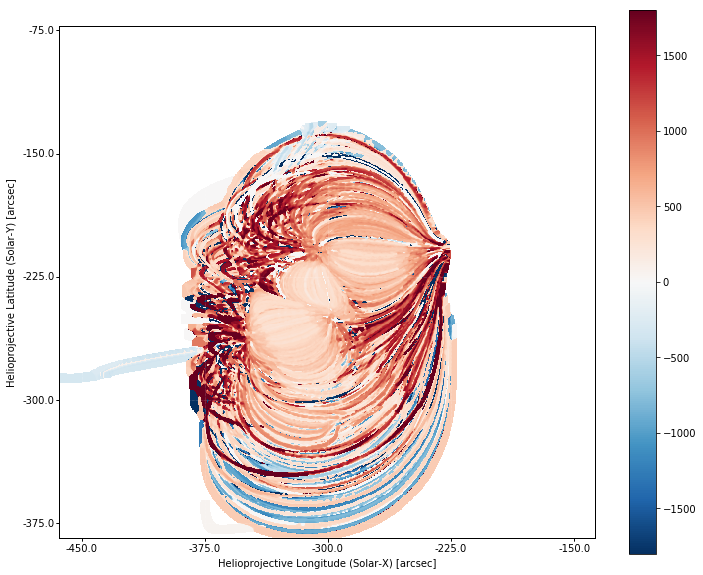

In [42]:
plt.figure(figsize=(12,10))
m_cor = cor_map94_335
m_tl = tl_map94_335
data_tl = np.where(m_cor.data >= 500., m_tl.data, np.nan)
m_tl = sunpy.map.GenericMap(data_tl,m_tl.meta,plot_settings=m_tl.plot_settings)
m_tl.plot(vmin=-(0.5*u.hour).to(u.s).value,
          vmax=(0.5*u.hour).to(u.s).value,
          cmap='RdBu_r',#bgry_004_idl_cmap,
          title=False
         )
plt.colorbar()

In [ ]:
ts1 = distaia.rechunk(distaia.time.shape+(distaia.shape[0]//10,distaia.shape[1]//10))['335'][:,:,250:260].mean(axis=(1,2))
ts2 = distaia.rechunk(distaia.time.shape+(distaia.shape[0]//10,distaia.shape[1]//10))['171'][:,:,250:260].mean(axis=(1,2))

In [ ]:
ts1_scaled = (ts1 - ts1.mean())/ts1.std()
ts2_scaled = (ts2 - ts2.mean())/ts2.std()

In [ ]:
n_timelags = distaia.time.shape[0]*2 - 1

In [ ]:
cc = da.fft.irfft(da.fft.rfft(ts1_scaled[::-1], n=n_timelags)
                  * da.fft.rfft(ts2_scaled, n=n_timelags), n=n_timelags)

In [ ]:
foo = cc.compute()

In [ ]:
i_b = np.where(np.logical_and(timelags >= -(6*u.hour).to(u.s),timelags <= (6*u.hour).to(u.s)))
plt.plot(timelags[i_b],foo[i_b])
plt.xlim((-2*u.hour).to(u.s).value,(2*u.hour).to(u.s).value,)
plt.axvline(x=0,ls='--',color='k')

In [ ]:
read_templates = {wav: read_template.format(wav) for wav in ['94','131','171','193','211','335']}

In [ ]:
filebytes = {wav: dask.bytes.open_files(temp,) for wav, temp in read_templates.items()}

In [ ]:
futures = {wav: client.map(get_header, fnames) for wav, fnames in filebytes.items()}
headers = {wav: client.gather(fut) for wav, fut in futures.items()}

In [ ]:
dtypes = {wav: [validate_dtype_shape(h) for h in head] for wav, head in headers.items()}
dtypes
assert all([d == list(dtypes.values())[0] for d in dtypes.values()])
dtype, shape = list(dtypes.values())[0][0]

In [ ]:
for c in dtypes:
    print(c)
    for i,p in enumerate(dtypes[c]):
        if p != ('float64',[500,500]):
            print(p,c,i)
            raise ValueError(p,c,i)

In [ ]:
list(dtypes.values())[0]

In [ ]:
dtypes['335'][0]

In [ ]:
arrs = {wav: [da.from_array(DelayedFITS(fn, shape=shape, dtype=dtype, hdu=0), chunks=shape)
         for fn in files] for wav, files in filebytes.items()}

In [ ]:
maps = {}
for wav in arrs.keys():
    maps[wav] = [delayed(sunpy.map.sources.AIAMap)(arr, header) for arr, header in zip(arrs[wav], headers[wav])]

In [ ]:
time = u.Quantity([h['t_obs'] for h in headers['94']], headers['94'][0]['tunit'])

In [ ]:
rarrs = {wav: [da.from_delayed(m.data, dtype=np.float64, shape=shape) for m in mps] for wav, mps in maps.items()}

In [ ]:
stacked = {wav: da.stack(arrs) for wav, arrs in rarrs.items()}

In [ ]:
stacked = {wav: d.rechunk(time.shape+(shape[0]//10,shape[1]//10)) for wav, d in stacked.items()}

Now, compute the timelag and correlation maps for each channel pair

In [ ]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

In [ ]:
timelags = u.Quantity(np.hstack([-np.diff(distaia.time).value.cumsum()[::-1], [0],
                                 np.diff(distaia.time).value.cumsum()]),distaia.time.unit)

In [ ]:
bounds = (-6*u.hour,6*u.hour)
bindices, = np.where(np.logical_and(timelags >= bounds[0], timelags <= bounds[1]))
i_start = bindices[0]
i_stop = bindices[-1] + 1

In [ ]:
correlation_maps = {}
timelag_maps = {}
for ca,cb in channel_pairs[:1]:
    cor = correlation_2d(distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10)),
                         timelags,f'{ca}',f'{cb}')
    # Timelag
    i_timelag = cor[i_start:i_stop,:,:].argmax(axis=0).compute()
    timelag = timelags[i_start:i_stop][i_timelag]
    meta = distaia.headers['94'][0].copy()
    del meta['instrume']
    del meta['t_obs']
    del meta['wavelnth']
    meta['bunit'] = 's'
    meta['comment'] = f'{ca}-{cb} timelag'
    plot_settings = {'cmap': 'RdBu_r', 'vmin': timelags[i_start:i_stop].value.min(),
                     'vmax': timelags[i_start:i_stop].value.max()}
    timelag_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(timelag,meta,plot_settings=plot_settings)
    # Max correlation
    max_cor = cor[i_start:i_stop,:,:].max(axis=0).compute()
    meta['bunit'] = ''
    meta['comment'] = f'{ca}-{cb} cross-correlation'
    plot_settings['cmap'] = 'plasma'
    del plot_settings['vmin']
    del plot_settings['vmax']
    correlation_maps[f'{ca}-{cb}'] = sunpy.map.GenericMap(max_cor,meta,
                                                          plot_settings=plot_settings)
    

In [ ]:
plt.figure(figsize=(10,10))
m_cor = correlation_maps['94-335']
m_tl = timelag_maps['94-335']
data_tl = np.where(m_cor.data >= 500., m_tl.data, np.nan)
m_tl = sunpy.map.GenericMap(data_tl,m_tl.meta,plot_settings=m_tl.plot_settings)
m_tl.plot(vmin=-(1*u.hour).to(u.s).value,vmax=(1*u.hour).to(u.s).value)
plt.show()

In [ ]:
stack_rechunk = distaia.rechunk(distaia.time.shape + (distaia.shape[0]//10,distaia.shape[1]//10))
ts94 = stack_rechunk['94'][:,250,250]
ts335 = stack_rechunk['335'][:,250,250]

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(distaia.time,(ts94 - ts94.mean())/ts94.std(),label='94')
plt.plot(distaia.time,(ts335 - ts335.mean())/ts335.std(),label='335')
#plt.ylim(0,40)

In [ ]:
foo = distaia.maps['94'][0].compute()

In [ ]:
x,y = foo.world_to_pixel(foo.center)

In [ ]:
x,y = x.value//1,y.value//1

In [ ]:
x,y = np.round([x.value,y.value]).astype(np.int)

In [ ]:
x

In [ ]:
foo.data[y,x]

In [ ]:
tuple((np.array(foo.data.shape)//10).tolist())

In [3]:
foo = np.array([0,1,5,10,11,15,15.5,20])

In [5]:
np.diff(foo)

array([1. , 4. , 5. , 1. , 4. , 0.5, 4.5])

In [6]:
np.gradient(foo)

array([1.  , 2.5 , 4.5 , 3.  , 2.5 , 2.25, 2.5 , 4.5 ])

In [28]:
min([1*u.s,3*u.s,10*u.s,0*u.s])

<Quantity 0. s>

In [29]:
for cube in aiatimelags:
    print(cube.time)

KeyError: '0'